# Point Cloud Optimization

In [1]:
import multipers as mp
from multipers.data import noisy_annulus, three_annulus
import multipers.ml.point_clouds as mmp
import multipers.ml.signed_measures as mms
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
import torch as t
import multipers.io as mio
import torch
# t.autograd.set_detect_anomaly(True)
import multipers.torch.rips_density as mpt
from multipers.plots import plot_signed_measures, plot_signed_measure
from tqdm import tqdm

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


The goal of this notebook is to generate cycles on the modes of a fixed measure. 

In this example, the measure is defined (in the cell below) as a sum of 3 gaussian measures.

In [2]:
## The density function of the measure
# @torch.compile(dynamic=True)
def custom_map(x, sigma=.17, threshold=None):
    if x.ndim == 1:
        x = x[None,:]
    assert x.ndim ==2
    basepoints = t.tensor([[0.2,0.2], [0.8, 0.4], [0.4, 0.7]]).T
    out = -(t.exp( - (((x[:,:,None]- basepoints[None,:,:]) / sigma).square() ).sum(dim=1) )).sum(dim=-1)
    # out[out>t.median(out)] = t.median(out)
    return 1+out # 0.8 pour norme 1

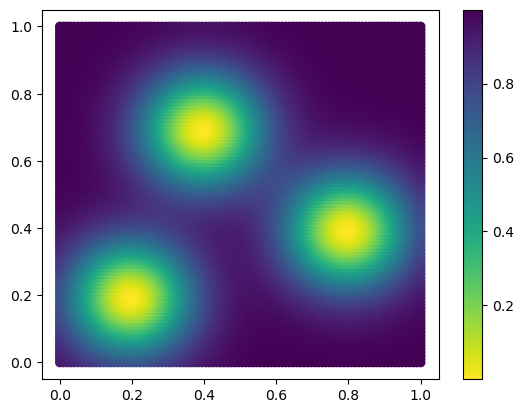

In [3]:
x= np.linspace(0,1,100)
mesh = np.meshgrid(x,x)
coordinates = np.concatenate([stuff.flatten()[:,None] for stuff in mesh], axis=1)
coordinates = torch.from_numpy(coordinates)
plt.scatter(*coordinates.T,c=custom_map(coordinates), cmap="viridis_r")
plt.colorbar()

We start from a uniform point cloud, that we will optimize

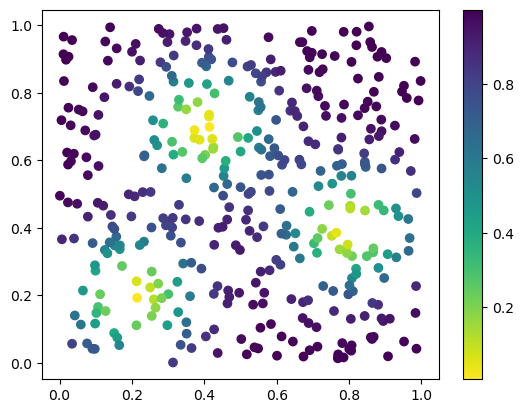

In [4]:
x = np.random.uniform(size=(400,2))
x = t.tensor(x, requires_grad=True)
plt.scatter(*x.detach().numpy().T, c=custom_map(x).detach().numpy(), cmap="viridis_r")
plt.colorbar()

The `function_rips_signed_measure` function is meant to compute signed measures from rips + function bifiltrations, in a `torch`-differentiable manner.

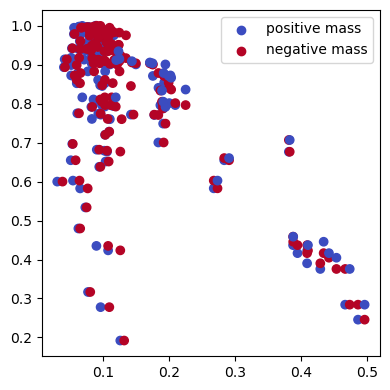

In [5]:
x = np.random.uniform(size=(300,2))
x = t.tensor(x, requires_grad=True)
sm_diff, = mpt.function_rips_signed_measure(
    x, threshold=np.inf, function=custom_map, degree=1, backend="multipers", num_collapses=-1, plot=True, verbose=True);

For this example we use the following loss. Given a signed measure $\mu$, define 

$$\mathrm{loss}(\mu) := \int\varphi(x) d\mu(x)$$ 

where $x := (r,d)\in \mathbb R^2$ ($r$ for radius, and $d$ for codensity value of the original measure) 
$$\varphi(x) = \varphi(r,d) = r\times(\mathrm{threshold}-d)$$

This can be interpreted as follows : 
 - we maximise the radius of the negative point (maximizing the radius of cycles)
 - we minimize the radius of positive points (the edges of the connected points creating the cycles). This create pretty cycles
 - we care more about cycles that are close to the mode (the `threshold-d` part). 
 The threshold is meant to prevent the cycles that are not close enough the the cycles to progressively stop to create loops.

In [6]:
threshold = .65
def softplus(x):
    return torch.log(1+torch.exp(x))
# @torch.compile(dynamic=True)
def loss_function(x,sm):
    pts,weights = sm
    radius,density = pts.T
    density = density
    
    phi = lambda x,d : (
        x
        * (threshold-d)
    ).sum()
    loss = phi(radius[weights>0], density[weights>0]) - phi(radius[weights<0], density[weights<0])
    return loss

loss_function(x,sm_diff) #test that it work. It should make no error + have a gradient

tensor(0.2537, grad_fn=<SubBackward0>)

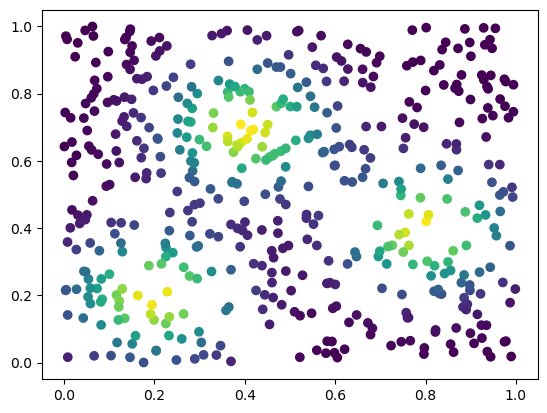

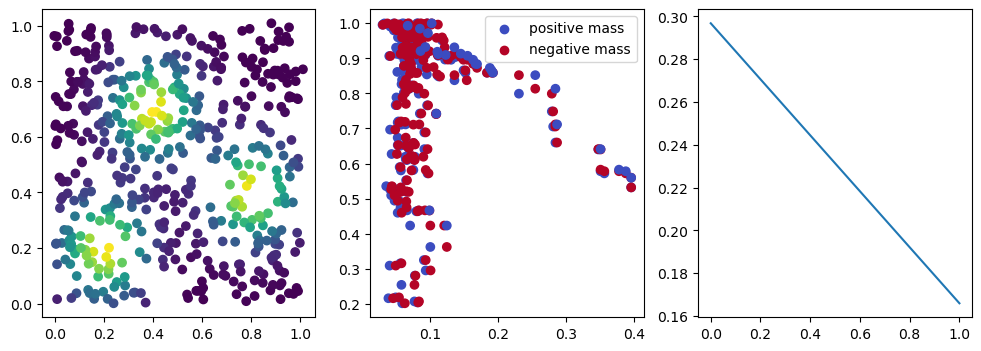

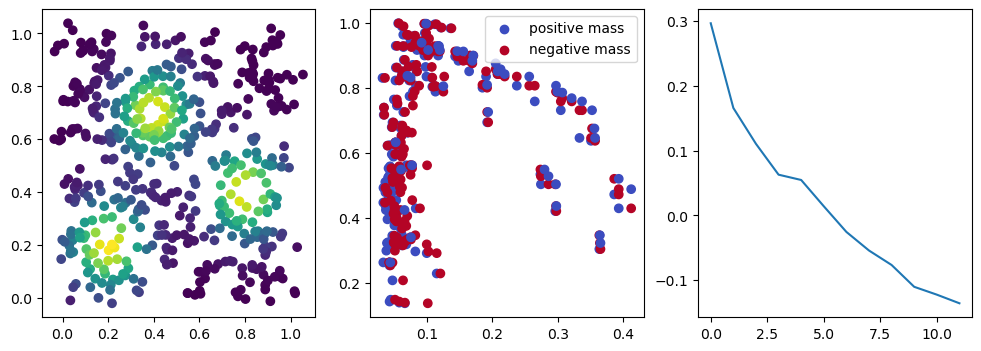

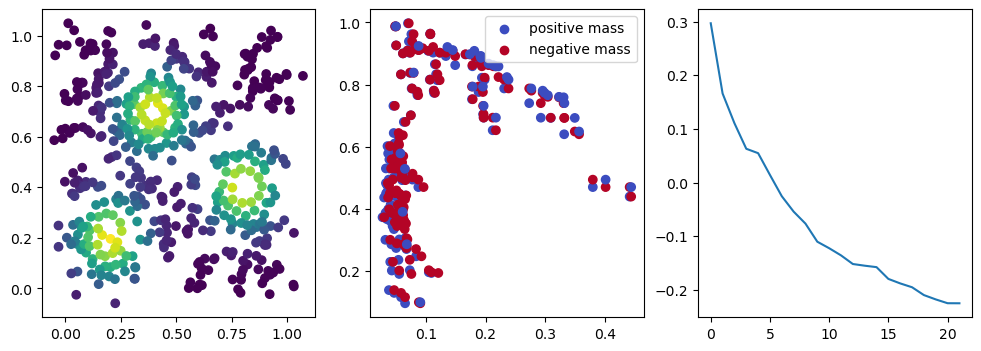

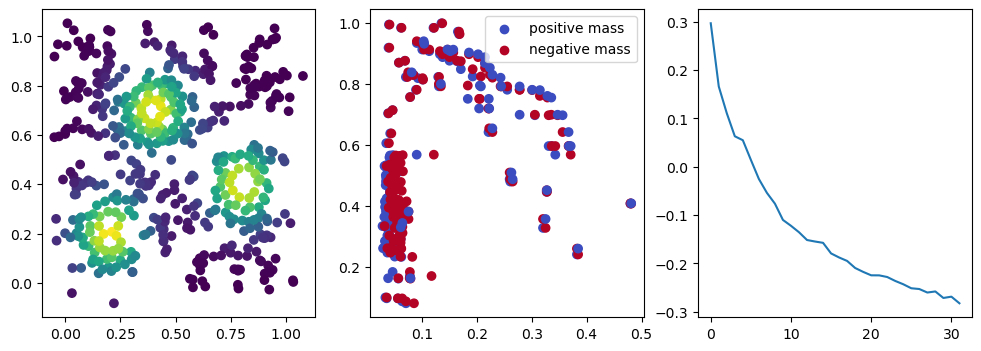

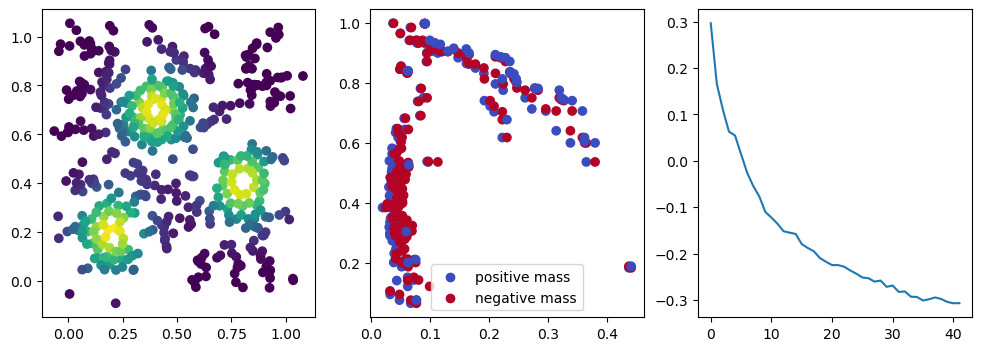

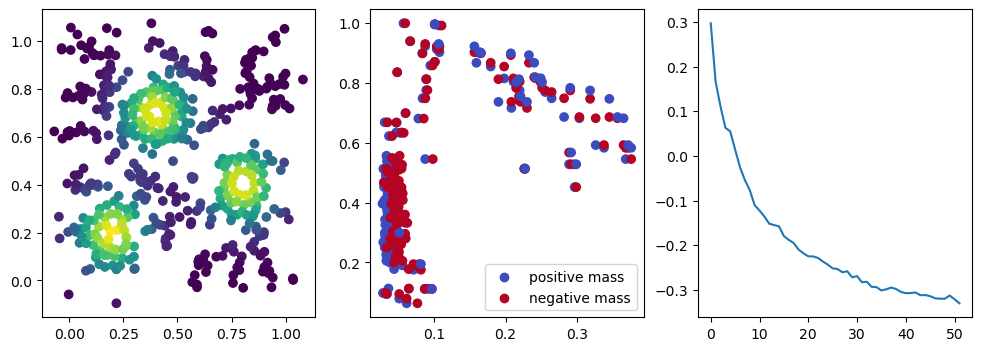

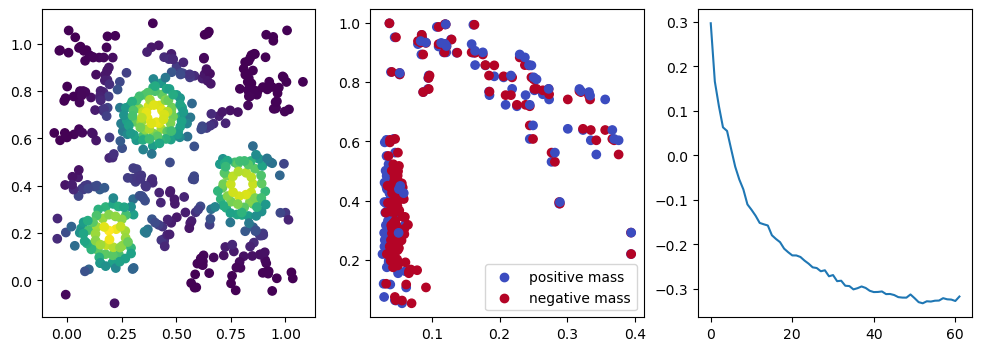

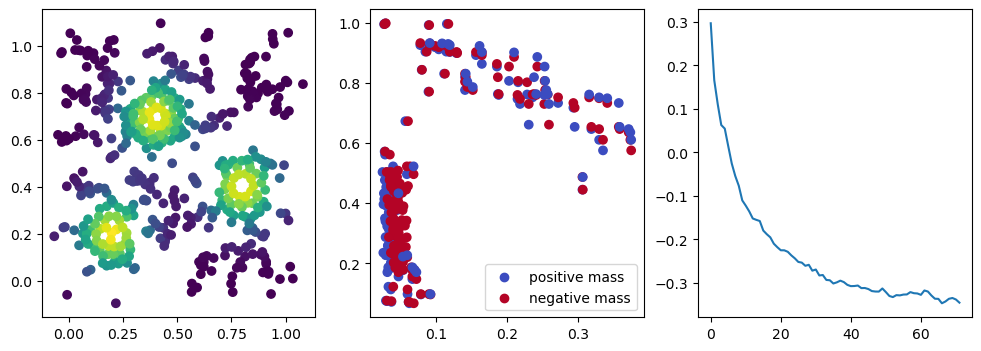

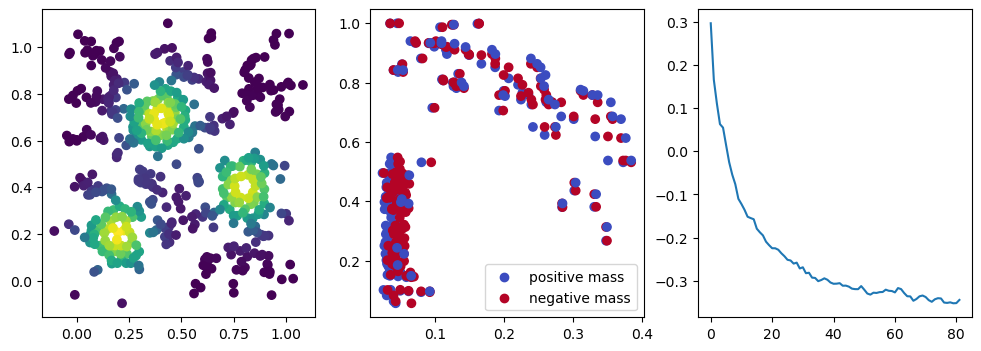

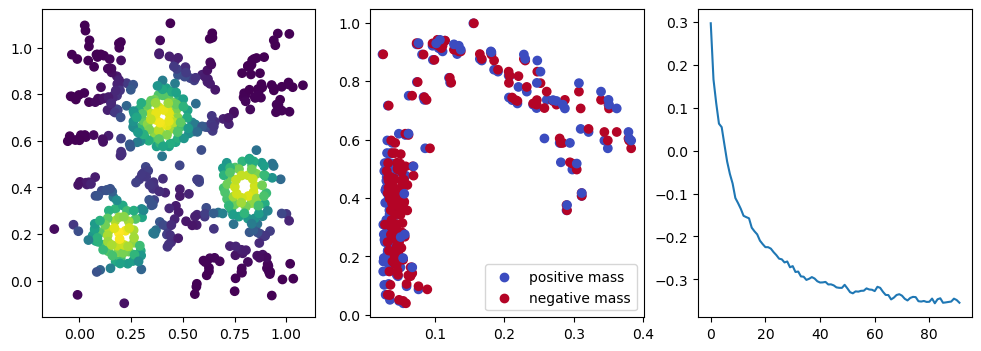

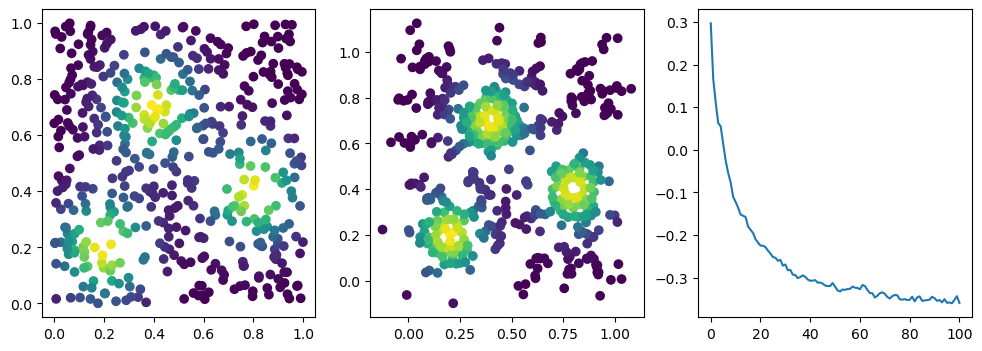

In [7]:
xinit = np.random.uniform(size=(500,2)) # initial dataset
x = t.tensor(xinit, requires_grad=True)
adam = t.optim.Adam([x], lr=0.01) #optimizer
losses = []
plt.scatter(*x.detach().numpy().T, c=custom_map(x, threshold=np.inf).detach().numpy(), cmap="viridis_r")
plt.show()
for i in range(101): # gradient steps
    # change backend to "multipers" if you don't have mpfree
    sm_diff, = mpt.function_rips_signed_measure(x, threshold=.5, function=custom_map, degree=1, backend="mpfree", num_collapses=100, plot=False, grid_strategy="exact");
    adam.zero_grad()
    loss = loss_function(x,sm_diff)
    # print("Loss", loss)
    loss.backward()
    adam.step()
    losses.append([loss.detach().numpy()])
    with torch.no_grad():
        if i %10 == 1: #plot part
            base=4
            ncols=3
            fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols*base, base))
            ax1.scatter(*x.detach().numpy().T, c=custom_map(x, threshold=np.inf).detach().numpy(), cmap="viridis_r", )
            plot_signed_measure(sm_diff, ax=ax2)
            ax3.plot(losses, label="loss")
            # plt.savefig(f"600_i_{i}_threshold{threshold}.png", dpi=500)
            plt.show()
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols*base, base))
ax1.scatter(*xinit.T, c=custom_map(t.tensor(xinit)).detach().numpy(),cmap="viridis_r")
ax2.scatter(*x.detach().numpy().T, c=custom_map(x).detach().numpy(),cmap="viridis_r")
ax3.plot(losses)
# plt.savefig(f"600final_threshold{threshold}.png", dpi=500)

plt.show()

We now observe a onion-like structure around the poles of the background measure.

How to interpret this ? The density constraints (in the loss) and the radius constraints are fighting against each other, 
therefore, each cycle has to balance itself to a local optimal ---an onion layer---.